# Is Fandango Still Inflating Results?

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system (Fandango is an online movie ratings aggregator) was biased and dishonest.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.
    
In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.


## Understanding the Data

In [35]:
import pandas as pd

previous = pd.read_csv("fandango_score_comparison.csv")
after = pd.read_csv("movie_ratings_16_17.csv")

print(previous)

print(after)

                                          FILM  RottenTomatoes  \
0               Avengers: Age of Ultron (2015)              74   
1                            Cinderella (2015)              85   
2                               Ant-Man (2015)              80   
3                       Do You Believe? (2015)              18   
4                Hot Tub Time Machine 2 (2015)              14   
..                                         ...             ...   
141                          Mr. Holmes (2015)              87   
142                                 '71 (2015)              97   
143                 Two Days, One Night (2014)              97   
144  Gett: The Trial of Viviane Amsalem (2015)             100   
145         Kumiko, The Treasure Hunter (2015)              87   

     RottenTomatoes_User  Metacritic  Metacritic_User  IMDB  Fandango_Stars  \
0                     86          66              7.1   7.8             5.0   
1                     80          67             

In [36]:
previous = previous[["FILM", "Fandango_Stars", "Fandango_Ratingvalue", "Fandango_votes", "Fandango_Difference"]]
after = after[["movie", "year", "fandango"]]

previous.head()
after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the README.md of the data set's repository, we can see that he used the following sampling criteria:

- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the data set's repository):

- The movie must have been released in 2016 or later.
- The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

# Changing the Goal of our Analysis
At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

## Isolating the Samples We Need
The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

In [37]:
previous_min_30_votes =  previous.shape[0] == sum(previous["Fandango_votes"] > 30)
print(previous_min_30_votes)

True


The other sample doesn't provide information about number of ratings. We should recheck if out data os truly representative and contains popular movies.

One quick way to ckeck the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website.

In [38]:
after.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


90% of the movies in our sample are popular. This is enough and we move forward with a bit more confidence.

Some movies were not released in 2015 and 2016. We need to isolate only the sample points that belong to our populations of interest.

In [42]:
previous["Year"] = previous["FILM"].str.extract("(\d{4})")
movies_2015 = previous[previous["Year"] == '2015']
movies_2016 = after[after["year"] == 2016]

movies_2016.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0


## Comparing Distribution Shapes for 2015 and 2016

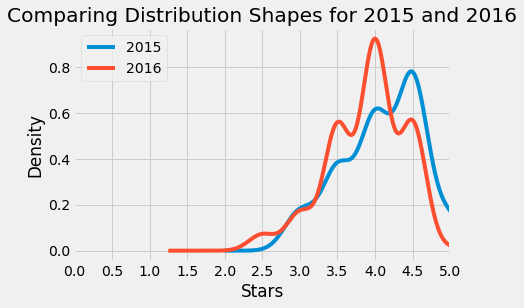

In [60]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline

plt.style.use('fivethirtyeight')

movies_2015["Fandango_Stars"].plot.kde(label="2015", legend=True)
movies_2016["fandango"].plot.kde(label="2016", legend=True)

plt.title("Comparing Distribution Shapes for 2015 and 2016")
plt.xlabel("Stars")
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))



plt.show()


Two aspects are striking on the figure above:

- Both distributions are strongly left skewed.
- The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.

The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

## Comparing Relative Frequencies

In [64]:
movies_2015["Fandango_Stars"].value_counts(normalize=True).sort_index() * 100

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [63]:
movies_2016["fandango"].value_counts(normalize=True).sort_index() * 100

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high rankings has significantly lower percentages compared to 2015. 
In 2016 0,5% of movies got ranking of 5 stars, while in 2015 it was almost 7%.
Rating od 4.5 were also more popular back in 2015 - there were approximately 13% more movies rated 4.5 in 2015 compared to 2016.
The minimum ranking is also lower - 2.5 stars in 2016, compared to 3 in 2015.

For other rankins the percentage went up in 2016.

## Determining the Direction of the Change
We'll take a couple of summary statistics (remember the distinction between sample statistics and population parameters) to get a more precise picture about the direction of the difference. We'll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [73]:
mean_2015 = movies_2015["Fandango_Stars"].mean()
median_2015 = movies_2015["Fandango_Stars"].median()
mode_2015 = movies_2015["Fandango_Stars"].mode()[0]

mean_2016 = movies_2016["fandango"].mean()
median_2016 = movies_2016["fandango"].median()
mode_2016 = movies_2016["fandango"].mode()[0]

summary = pd.DataFrame()
summary["2015"] = [mean_2015, median_2015, mode_2015]
summary["2016"] = [mean_2016, median_2016, mode_2016]
summary.index = ["mean", "meadian", "mode"]

summary

,2015,2016
mean,4.085271,3.887435
meadian,4.000000,4.000000
mode,4.500000,4.000000


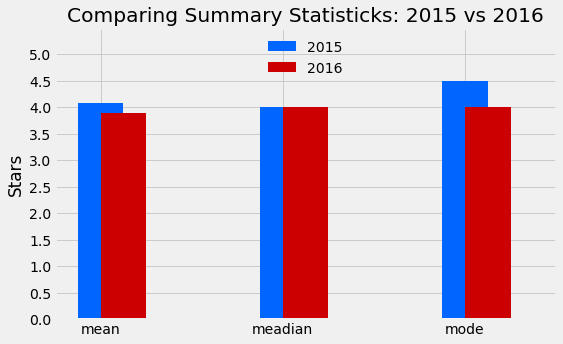

In [82]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title("Comparing Summary Statisticks: 2015 vs 2016")
plt.ylim(0,5.5)
plt.ylabel("Stars")
plt.yticks(arange(0,5.1,.5))
plt.legend(framealpha=0, loc='upper center')

plt.show()

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.